**10.7 [Computational] MCMC.** Setting up a basic Markov chain Monte Carlo is quite straightforward, as you will now demonstrate. Use the same dataset as in Problem 10.5, with four measurements with uncorrelated error bars, and consider the same model as there,
$y = mx$ (model 1).

**a)** Set up the MCMC algorithm in the single parameter m and run it for some reasonably large number of steps (say, 10,000). [If you wish, you can look up the Gelman-Rubin convergence criterion and track it as well.]

**b)** Report the acceptance rate of your chain. If the value is either far too large or too small (relative to the optimal rate of ballpark 0.25), then change the stepsize accordingly, repeat the MCMC run, and see if the acceptance rate improves.


**c)** Plot the posterior in m. Find the best-fit value of this parameter, and its 68% credible interval.


**d)** Calculate the Bayesian evidence of your model,
$$P(D|model)=\int \mathcal{L}(D|m)P(m)dm$$
Note that you should use the properly normalized prior so that
$$\int P(m)dm = 1$$
Adopt the range $m \in [0, 5]$, and a uniform prior so that $P (m) = const. [Note, it might be easiest to not use your MCMC calculation, but rather calculate the evidence directly by summing on a grid in m. ]

**e)** Now consider a more complicated model:
$y = mx + b$ (model 2), with two free parameters, m and b. Calculate the Bayesian evidence of this model as well. You don’t need to run MCMC, just evaluate the evidence by summing on a grid of (m,b). Adopt the same m range as in part d), and the range $b=[-2, 2]$. And a uniform prior as before, normalized as $$\int P(m)dmdb = 1$$
Then evaluate the Bayes factor
$$B_{21} = \frac{P(D|model 2)}{P(D|model 1)} = \frac{\int \mathcal{L}(D|m)P(m)dmdb}{\int \mathcal{L}(D|m)P(m)dm}$$
where the numerator and the denominator are the Bayesian evidences for the two models respectively. With your result for $B_{21}$, use the Jeffreys scale (Table 10.1) to assess if the data prefer model 2 over model 1.

Dataset: 
$$y(x=1)= 2.0 \pm 1.0$$
$$y(x=2)= 4.0 \pm 2.0$$
$$y(x=3)= 6.0 \pm 3.0$$
$$y(x=4)= 8.0 \pm 4.0$$
Assume these four measurements are independent and identically distributed and that each comes from a Gaussian distribution.


Below is pseudocode for the Metropolis-Hastings MCMC algorithm in Figure 10.6 in Huterer:

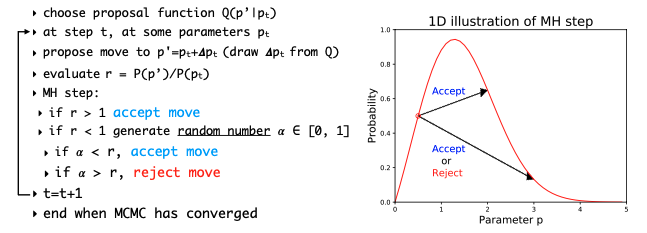

In [61]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from numpy import random
from scipy import stats as st
from scipy.integrate import quad, nquad
import statistics

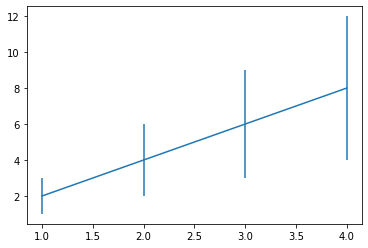

In [156]:
#dataset
xs = [1.0, 2.0, 3.0, 4.0]
ys = [2.0, 4.0, 6.0, 8.0] #how to include error bars?
err=[1,2,3,4]
plt.errorbar(xs, ys, err)
data=np.array(list(zip(xs, ys)), dtype=[('x',float),('y',float)])

x and y have a linear relationship, hence why we pick y=mx as our model

Part A:

In [130]:
# using default sigma = x for variance (width of Gaussian dist) since problem does not specify
# modified likelihood to be general for b-parameter
# added sigma_factor parameter, modifies sigma value by multiplying x by a specified factor
def likelihood(m, data, b=0, sigma_factor=1):
    chi_squared_sum = 0
    for row in data:
        x = row['x']
        y_data = row['y']
        y_model = m * x + b
        chi_squared_sum+=(y_model - y_data)**2/(x*sigma_factor)**2
    #return chi_squared_sum
    likelihood = np.exp(-1*(chi_squared_sum)/2)
    return likelihood
        
        

In [131]:
print(likelihood(2.5, data))
print(likelihood(2, data))

0.6065306597126334
1.0


In [160]:
def MCMC_1_param(data, sigma_factor=1, scale=2.5):
    # initialization

    steps = 10000 #10,000 steps
    p_0 = random.uniform(low=0.0, high=5.0) #choose an initial value for p within the range for p
    states = [p_0] #add initial p to states
    accepted = 0
    print(states)
    #posterior_in_m = [p_0,likelihood(p_0, data)]
    posterior_m = [likelihood(p_0, data)]

    for t in range(steps):
    
        p_current = states[-1] #grab most recent value in states
        p_new = random.normal(loc=p_current, scale = scale) # generate a candidate p' for the next sample
        likelihood_p_new = likelihood(p_new, data)
        #posterior_in_m.append([p_new, likelihood_p_new])# TODO: this needs to be normalized 
        posterior_m.append(likelihood_p_new)
        r = likelihood_p_new/likelihood(p_current, data) # uniform prior, therefore post/post = lik/lik
    
        if r >= 1: 
            states.append(p_new)
            accepted += 1
        elif r < 1:
            alpha = random.rand()
            if r > alpha:
                states.append(p_new)
                accepted += 1
            else: states.append(p_current)
    
    # Burn in - I omit the first 1000 states to remove dependence on initial conditions    
    states = states[1000:]
    posterior_m = posterior_m[1000:]
    return states, posterior_m
    

In [133]:
# initialization

steps = 10000 #10,000 steps
p_0 = random.uniform(low=0.0, high=5.0) #choose an initial value for p within the range for p
states = [p_0] #add initial p to states
accepted = 0
print(states)
#posterior_in_m = [p_0,likelihood(p_0, data)]
posterior_m = [likelihood(p_0, data)]

for t in range(steps):
    
    p_current = states[-1] #grab most recent value in states
    p_new = random.normal(loc=p_current, scale = 2.5) # generate a candidate p' for the next sample
    likelihood_p_new = likelihood(p_new, data)
    #posterior_in_m.append([p_new, likelihood_p_new])# TODO: this needs to be normalized 
    posterior_m.append(likelihood_p_new)
    r = likelihood_p_new/likelihood(p_current, data) # uniform prior, therefore post/post = lik/lik
    
    if r >= 1: 
        states.append(p_new)
        accepted += 1
    elif r < 1:
        alpha = random.rand()
        if r > alpha:
            states.append(p_new)
            accepted += 1
        else: states.append(p_current)
    
# Burn in - I omit the first 1000 states to remove dependence on initial conditions    
states = states[1000:]
posterior_m = posterior_m[1000:]

[4.681485793858074]


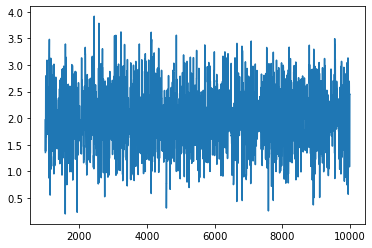

In [134]:
plt.plot(np.arange(1000, 10001), states)


(0.0, 5.0)

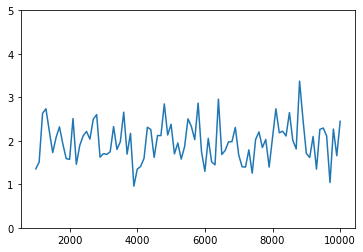

In [135]:
#plot only every 100th state (better visualization)
plt.plot(np.arange(1000, 10001)[::100], states[::100])
plt.ylim(0,5)

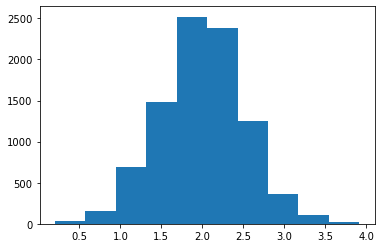

In [136]:
freq, bins, _ = plt.hist(states)

In [137]:
# print MCMC predicted value of m (peak of the histogram)
m_MCMC = bins[np.where(freq == freq.max())][0]
print(m_MCMC)

1.6867401209230288


In [138]:
# TODO: Gelman Rubin Convergence

Part B:

In [139]:
# print acceptance rate
print(f'Acceptance rate: {accepted/steps}')

Acceptance rate: 0.2425


Part C:

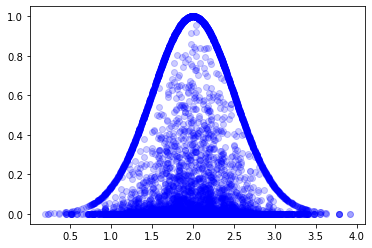

In [140]:
# TODO: Plot the posterior in m. Find the best-fit value of this parameter, and its 68% credible interval.
# TODO: properly normalize posterior (currently plotting likelihood)

# save p_new, posterior(p_new) in a list as I go over the t's 
# plot posterior(p_new) vs p_new here

#plt.plot(np.arange(0, 10001), posterior_m)
#plt.ylim(0,1)
#plt.plot(posterior_in_m[0])
plt.plot(states, posterior_m, 'bo', alpha=0.2)

In [141]:
np.median(states)

1.9960226910986245

In [142]:
statistics.stdev(states)

0.5121500633000725

In [143]:
conf_int = st.norm.interval(0.68, loc=np.mean(states), 
    scale=statistics.stdev(states))
print(conf_int) # 68% interval

(1.4882316654043022, 2.5068550010745647)


Part D:

In [144]:
def bayesian_evidence(data): 
    # TODO: Incorporate normalized prior
    integrand = lambda m: likelihood(m, data)*1/(5-0) # likelihood times normalized prior
    integral = quad(integrand, 0, 5) # uniform prior so prior const
    return(integral[0])
    

In [145]:
bayesian_evidence_model1 = bayesian_evidence(data)
bayesian_evidence_model1

0.250654888412772

In [146]:
# Calculate Bayesian evidence
ms = np.mgrid[0:5] # change this to np.meshgrid for more control?
print(ms)

[0 1 2 3 4]


Part E:

In [147]:
def bayesian_evidence_2param(data, b1, b2): 
    # TODO: Incorporate normalized prior
    integrand = lambda m,b: likelihood(m, data)*1/(5-0) *1/(b2-b1) # likelihood times normalized prior
    integral = nquad(integrand, [[0, 5], [b2,b1]]) # uniform prior so prior const
    return (integral[0])
    

In [148]:
bayesian_evidence_model2 = bayesian_evidence_2param(data, -2, 2)
bayesian_evidence_model2

-0.250654888412772

In [149]:
bayes_factor_21 = bayesian_evidence_model2/bayesian_evidence_model1
bayes_factor_21

-1.0

In [150]:
np.absolute(np.log(bayes_factor_21))

/var/folders/99/vfh56jrs1nqcj8zqtcs5fkv40000gn/T/ipykernel_7612/3508731560.py:1: RuntimeWarning: invalid value encountered in log
  np.absolute(np.log(bayes_factor_21))


nan

In [151]:
X = np.linspace(0, 5, 50)
Y = np.linspace(-2, 2, 50)
ms, bs = np.meshgrid(X, Y)

In [152]:
 # likelihood is not normalized, posterior is proportional to likelihood due to uniform prior


posteriors = np.zeros((50,50))

for i in range(50):
    for j in range(50):
        posteriors[i,j] = likelihood(ms[i,j], data, b=bs[i,j]) # posterior equal to likelihood since uniform prior

Text(0, 0.5, 'Parameter 2: b')

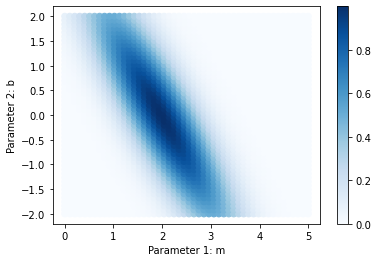

In [153]:
color = []
plt.scatter(ms, bs, c=posteriors, cmap="Blues")
plt.colorbar()
plt.xlabel("Parameter 1: m")
plt.ylabel("Parameter 2: b")

BONUS: Reduce error bars by factor of 10, shuffle y data points by some small amount, run MCMC again

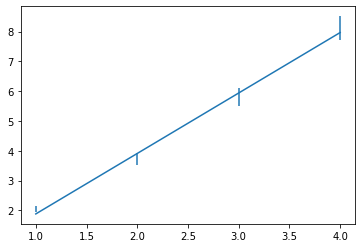

In [155]:
#generate dataset
xs = [1.0, 2.0, 3.0, 4.0]
ys_original = [2.0, 4.0, 6.0, 8.0] #how to include error bars?
ys = [y + np.random.normal(scale=0.2) for y in ys_original]

err=[0.1,0.2,0.3,0.4]

a, b = np.polyfit(xs, ys, 1)

plt.errorbar(xs, ys, err, 0, 'none')
plt.plot(xs, a*np.array(xs)+b)
data_shuffled=np.array(list(zip(xs, ys)), dtype=[('x',float),('y',float)])

In [157]:
print(likelihood(2.5, data_shuffled, sigma_factor=0.1))
print(likelihood(2, data_shuffled, sigma_factor=0.1))

1.0735337111051593e-25
0.25424914751083416


In [161]:
states_sh, posterior_m_sh = MCMC_1_param(data_shuffled, sigma_factor=0.1)

[2.347999008406554]


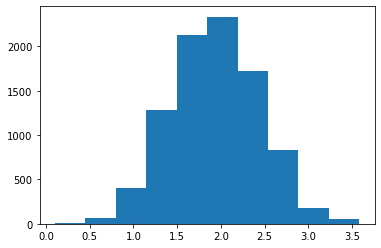

In [162]:
freq, bins, _ = plt.hist(states_sh)

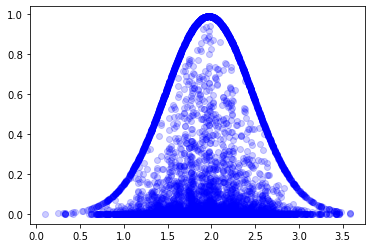

In [163]:
plt.plot(states_sh, posterior_m_sh, 'bo', alpha=0.2)

In [164]:
np.median(states_sh)

1.940464545684771

In [165]:
statistics.stdev(states_sh)

0.4949436854200618

In [167]:
conf_int = st.norm.interval(0.68, loc=np.mean(states_sh), 
    scale=statistics.stdev(states_sh))
print(conf_int) # 68% interval

(1.4422670314143313, 2.4266683308360686)


BONUS 2: Run MCMC for 2 parameters, m and b